In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import geojson
import geopandas as gpd
from shapely.geometry import Polygon as shpPolygon

from scipy.optimize import differential_evolution
from numba import jit

from hm import gr4j, gr4j_bounds

from bokeh.plotting import figure, show, output_file
from bokeh.io import save as save_html

import zipfile
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
meta_data = pd.read_csv("../data/raw_shapes/ESP_meta.csv")[["STATION", "NAME", "SQ_KM"]]
#consistency
meta_data.at[314, "STATION"] = 38001
meta_data.at[315, "STATION"] = 39001

In [3]:
def get_boundaries(polygon):
    """
    Function for receiving boundaries
    from the provided .geojson file.
    Use for further creating grid polygons
    for intersection with our input .geojson polygon
    
    Input:
    .geojson polygon
    You can import it using Qgis or 
    use geojson.io webservice.
    
    Output:
    [west, south, east, north] rounded to integer coordinates
    
    """
    
    lons = [coords[0] for coords in polygon["geometry"]["coordinates"][0]]
    lats = [coords[1] for coords in polygon["geometry"]["coordinates"][0]]
    
    lon_min, lon_max = np.min(lons), np.max(lons)
    lat_min, lat_max = np.min(lats), np.max(lats)
    
    west = np.min([np.floor(lon_min), np.ceil(lon_min)])
    east = np.max([np.floor(lon_max), np.ceil(lon_max)])
    south = np.min([np.floor(lat_min), np.ceil(lat_min)])
    north = np.max([np.floor(lat_max), np.ceil(lat_max)])
    
    return [west, south, east, north]

def get_era5_polygons_geodf(boundaries, gridsize=0.25):
    
    """
    Fuction for obtaining ERA5 grid polygons
    for further intersection with .geojson
    watershed representation polygon
    
    Input:
    1. boundaries from get_boundaries() function
    2. gridsize (default=0.25) of ERA5 dataset
    
    Output:
    Geodataframe (geopandas package data container)
    with grid polygons cover watershed area
    
    """    
    # read in already prepared lats/lons
    lons_c = np.load("../data/era5_uk_lons.npy")
    lats_c = np.load("../data/era5_uk_lats.npy")
    
    # because of the care of geographical latitude consistency
    # we need to keep longitude boundaries between -180 and 180
    # so, it is not so simple substractinf of 180
    # because of they have the same 0 - grinvich meridian
    # so we need to transform only values from 180 to 360
    # to from 180 to -180
    # previous calculations were wrong
    # lons_c = lons_c - 180
    lons_c = np.where(lons_c > 180, lons_c - 360, lons_c)
    
    hg = gridsize / 2 # half gridsize
    
    # save only useful longitudes based on conditioning under boundaries
    # +-5 added for instances where is no grid centers 
    # between boundaries (small catchments)
    lons_c = lons_c[(lons_c >=boundaries[0]-5)&(lons_c<=boundaries[2]+5)]
    lats_c = lats_c[(lats_c>=boundaries[1]-5)&(lats_c<=boundaries[3]+5)]
      
    polygons = [shpPolygon([ (x-hg, y-hg), (x-hg, y+hg), (x+hg, y+hg), (x+hg, y-hg), (x-hg, y-hg) ]) 
                for x in lons_c for y in lats_c]
    
    geodf = gpd.GeoDataFrame(geometry=polygons)
    
    # for absolute consistency with grid cell centroids
    geodf["lat_c"] = [ y for x in lons_c for y in lats_c]
    geodf["lon_c"] = [ x for x in lons_c for y in lats_c]
    
    return geodf

def get_me_ERA5_gridcell_weights(file, gridsize=0.25, full_data=False):
    
    '''
    Function converts .geojson file of basin delineation
    to weight matrix for further meteo forcing averaging
    for using as input in lumped hydrological models
    
    Input:
    1. file - .geojson polygon file.
    You can import it using Qgis or 
    use geojson.io webservice.
    2. gridsize (default=0.125) of ERA-Interim
    global product resolution
    3. full_data (default=False) return 
    geodataframe result (can be plotted)
    Output:
    1. Default (full_data=False): pandas dataframe
    with ['lon', 'lat', 'weight'] columns
    2. Extended (full_data=True): geopandas dataframe
    with added "geometry" field
    
    source:
    https://gis.stackexchange.com/questions/178765/intersecting-two-shapefiles-from-python-or-command-line

    '''
    # make geoDataFrame from basin file
    watershed = gpd.read_file(file)
    
    # make geoDataFrame of grid cells matrix
    with open(file) as f:
        basin_json = geojson.loads(f.read())["features"][0]
    
    # retrive geodataframe representation of grid cell polygons
    grid = get_era5_polygons_geodf(get_boundaries(basin_json), gridsize=gridsize)
    
    data = []
    
    for index, wtr in watershed.iterrows():
        for index2, cell in grid.iterrows():
            if wtr['geometry'].intersects(cell['geometry']):
                data.append({'geometry': wtr['geometry'].intersection(cell['geometry']), 
                             'lon': cell['lon_c'],
                             'lat': cell['lat_c'],
                             'area': wtr['geometry'].intersection(cell['geometry']).area})

    df = gpd.GeoDataFrame(data,columns=['geometry', 'lon', 'lat', 'area'])

    # add weight for each gridcell
    df['weight'] = df['area'] / df['area'].sum()
    
    # Because of global (!) ERA (and the same is valid for CMIP5) 
    # dataset has a longitute representation from 0 to 360
    # instead of geographical projection representation from -180 to +180
    # we need to add +180 to "lon" values 
    # for further valid data acqusition from global ERA datasets (tmin, tmax)
    # link: https://software.ecmwf.int/wiki/display/CKB/ERA-Interim%3A+What+is+the+spatial+reference
    # so, finally! ti is not so easy too!
    # we need to perform backward convertion 
    # (according to forward convertion in get*polygons_geodf functions)
    # previous (wrong) decision
    # df['lon'] = df['lon'] + 180
    #df["lon"] = np.where(df["lon"] < 0, df["lon"] + 360, df["lon"])
        
    # despite changes in df['lon'] values
    # returned geometries with full_data=True are geographical (lon:[-180,180])!
    if full_data:
        return df
    
    return df[['lon', 'lat', 'weight']]

def oudin2005(df_row):
    
    # climatic temperature was changed by observed one
    
    tmean, lat, doy = df_row["t2m"], df_row["lat"], df_row["doy"]
    
    # Reference: http://www.fao.org/docrep/x0490e/x0490e07.htm
    # use with caution for latitudes out of range 0-67 degrees

    # Convert latitude [degrees] to radians
    latrad = np.deg2rad(lat)

    # Part 2. Extraterrrestrial radiation calculation
    # set solar constant (in W m-2)
    Rsc = 1367
    # calculate solar declination dt (in radians)
    dt = 0.409 * np.sin(2 * np.pi / 365 * doy - 1.39)
    # calculate sunset hour angle (in radians)
    # calculate sunset hour angle [radians]
    # accorging to sunset_hour_angle_func() in PyET0
    cos_ws = -np.tan(latrad) * np.tan(dt)
    ws = np.arccos(min(max(cos_ws, -1.0), 1.0))
    # Calculate sunshine duration N (in hours)
    N = 24 / np.pi * ws
    # Calculate day angle j (in radians)
    j = 2 * np.pi / 365.25 * doy
    # Calculate relative distance to sun
    dr = 1.0 + 0.03344 * np.cos(j - 0.048869)
    # Calculate extraterrestrial radiation (J m-2 day-1)
    Re = Rsc * 86400 / np.pi * dr * (ws * np.sin(latrad) * np.sin(dt) + np.sin(ws) * np.cos(latrad) * np.cos(dt))
    # convert from J m-2 day-1 to MJ m-2 day-1
    Re = Re/10**6

    # Part 3. Avearge daily temperatures calculation derived from long-term observations
    #Ta = np.array([tmean[tmean.index.dayofyear == x].mean() for x in range(1, 367)])

    # Part 4. PET main equation by (Oudin et al., 2005)
    # lambda (latent heat flux const) = 2.45 MJ kg-1
    # ro (density of water const) = 1000 kg m-3
    # PE im m day -1 should be converted to mm/day (* 10**3)
    # PE = ( Re / (2.45*1000) ) * ( (Ta+5) /100 ) * 10**3
    # threshhold condition
    # if Ta+5>0 - use Oudin formula, else set to zero
    #PE = np.where(Ta+5 > 0, ( Re / (2.45*1000) ) * ( (Ta+5) /100 )*10**3, 0)
    PE = np.where(tmean+5 > 0, ( Re / (2.45*1000) ) * ( (tmean+5) /100 )*10**3, 0)

    return PE

def delineation2list(data_instance, delineation_instance, variable):
        
    # handler for variable
    # list of pandas.Series which than we will convert to dataframe
    results_list = []
    
    #print(len(delineation_instance), " nodes for extraction")
    for idx, row in delineation_instance.iterrows():
        
        #print(idx)
        # obtain values from grid cells
        point = data_instance[variable].sel(longitude=row["lon"],
                                            latitude=row["lat"]).to_series() * row["weight"]

        # append obtained series to a list
        results_list.append(point)
    
    # close data reference
    # data_instance.close()
    
    return results_list

def temp2pet(tmean_list, delineation_instance):
    
    # handler for variable
    # list of pandas.Series which than we will convert to dataframe
    pet_list = []
    
    for idx, row in delineation_instance.iterrows():
        
        tmean = tmean_list[idx] / row["weight"]
               
        df = pd.DataFrame(tmean)
        
        #print(tmean)
        
        df["lat"] = row["lat"]
        
        #df.rename(index=str, columns={"t2m":"tmean", "lat": "lat"}, inplace=True)
        df.index = pd.to_datetime(df.index)
        df["doy"] = df.index.dayofyear     
        
        df["pet"] = df.apply(oudin2005, axis=1)
        
        # append obtained series to a list
        pet_list.append(df["pet"] * row["weight"])
       
    return pet_list

def extract_ERA_reanalisys_data(geojson_file):
    
    # calculate delineation   
    ERA_delineation = get_me_ERA5_gridcell_weights(file=geojson_file)
    
    # read the data
    ERA_precipitation = xr.open_dataset("../data/era5_uk_daily_prec.nc")
    ERA_temp_mean = xr.open_dataset("../data/era5_uk_daily_temp.nc")
    
    # ERA precipitation data
    precipitation_list = delineation2list(data_instance=ERA_precipitation, 
                                          delineation_instance=ERA_delineation, variable="tp")
    
    # ERA minimum temperature data
    temperature_mean_list = delineation2list(data_instance=ERA_temp_mean,
                                             delineation_instance=ERA_delineation, variable="t2m")    
    
    #return precipitation_list, temperature_min_list, temperature_max_list
    evaporation_list = temp2pet(tmean_list=temperature_mean_list,
                                delineation_instance=ERA_delineation)
    
    # create dataframes and store our averaged series
    lumped_out = pd.DataFrame( {'Temp': pd.concat(temperature_mean_list, axis=1).sum(axis=1),
                                'Prec': pd.concat(precipitation_list, axis=1).sum(axis=1), 
                                'Evap': pd.concat(evaporation_list, axis=1).sum(axis=1)} )
    
    #lumped_out["Temp"] = lumped_out["Tmin"] + lumped_out["Tmax"] / 2.0
        
    #return temperature_mean_list
    return lumped_out

def hm_calibration(data_instance, model, bounds, seed=1010):
    
    """
    Calibration meta function for hydrologic models
    
    Input :
    1. data_instance: pandas dataframe with data:
        "Obs"   : observed streamflow (mm/day)
        "Temp"   : mean daily temperature (Celsius)
        "Prec"   : daily sum of precipitation (mm)
        "Evap" : daily potential evapotranspiration (mm)
    2. model :
        function for running hydrologic model
    3. bounds :
        function for deriving lower and upper bounds
        of model parameters for calibration
    4. seed :
        random seed number for differential evolution algorithm
    
    Output:
    #1. runoff :
        Simulated (Qsim) runoff
    2. opt_par :
        optimal set of model parameters
    #3. NS :
        Nash-Sutcliffe efficiency criteria
    """
      
    _Q   = data_instance["Obs"].values
    _T   = data_instance["Temp"].values
    _P   = data_instance["Prec"].values
    _PET = data_instance["Evap"].values
    
    # add warmup
    # simply full period
    
    Qobs = np.concatenate([_Q,  _Q])
    T    = np.concatenate([_T,  _T])
    P    = np.concatenate([_P,  _P])
    PET  = np.concatenate([_PET, _PET])
    
    def NS_loss(params):
        # simulate hydrograph
        Qsim = model(T, P, PET, params)
        Qm = np.nanmean(Qobs)
        # calculate objective function value
        return np.nansum((Qobs-Qsim)**2)/np.nansum((Qobs-Qm)**2)
    
    result = differential_evolution(NS_loss, 
                                    bounds=bounds(), 
                                    maxiter=1000, 
                                    polish=True, 
                                    disp=False, 
                                    seed=seed)
    
    opt_par = result.x
    
    Qsim = model(T, P, PET, opt_par)
    
    # cut the warmup period
    Qsim = Qsim[len(_Q):].copy()
    Qobs = Qobs[len(_Q):].copy()
    
    NS = 1 - np.nansum((Qobs-Qsim)**2)/np.nansum((Qobs-np.nanmean(Qobs))**2)
    
    #print("NS : {}".format(np.round(NS, 2)))
    
    #runoff = pd.DataFrame({"Qobs": Qobs, "Qsim": Qsim}, index=data_instance.index)
    
    return Qsim, opt_par, NS

def generate_future_data(data_instance):
    
    observed_rainfall = data_instance["Prec"]
    
    Tclim   = np.array([data_instance["Temp"].loc[data_instance["Temp"].index.dayofyear == doy].mean() for doy in range(1, 367)])
    PETclim = np.array([data_instance["Evap"].loc[data_instance["Evap"].index.dayofyear == doy].mean() for doy in range(1, 367)])
    
    future_dates = pd.date_range("2016-01-01", "2020-12-2", freq="D")
    
    lenght = len(future_dates)
    
    df = pd.DataFrame(index=future_dates)
    
    np.random.seed(42)
    # 1. Constant mean obs rain
    df["MeanRain"] = np.ones(lenght) * np.median(observed_rainfall)
    
    # 2. Constant max obs rain
    df["MaxRain"] = np.ones(lenght) * np.max(observed_rainfall)
    
    # 3. Random sampling from distribution
    df["RandomRain"] = np.random.random(lenght) * np.max(observed_rainfall)
    
    df["Temp"] = np.array([Tclim[i.dayofyear-1] for i in df.index])
    
    df["Evap"] = np.array([PETclim[i.dayofyear-1] for i in df.index])
    
    return df

def df2html(df, df_future, station_number, station_name):
    
    title = f"{station_name}"
    
    p1 = figure(title=title, x_axis_type="datetime", plot_width=500, plot_height=300)
    p1.grid.grid_line_alpha=0.5
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = 'Runoff, mm/day'

    p1.line(df.index, df["Sim"], color='deepskyblue', legend='Historical')
    p1.line(df_future.index, df_future["MeanRunoff"], color='seagreen', legend='MeanRainRunoff')
    p1.line(df_future.index, df_future["MaxRunoff"], color='crimson', legend='MaxRainRunoff')
    p1.line(df_future.index, df_future["RandomRunoff"], color='turquoise', legend='RandomRainRunoff')
    p1.legend.location = "top_left"

    output_file(f"../docs/{station_number}.html", title="4Y11M2D")
    save_html(p1)
    
    #show(p1)

In [4]:
def generate_html(station_id, station_name):
    
    path_runoff = f"../data/runoff/{station_id}.pkl"
    path_shape  = f"../data/shapes/{station_id}.geojson"
    
    runoff = pd.read_pickle(path_runoff)
    shape  = gpd.read_file(path_shape)
    
    meteo = extract_ERA_reanalisys_data(path_shape)
    
    data = pd.concat([runoff, meteo], axis=1)
    
    qsim, opt_par, ns = hm_calibration(data, gr4j, gr4j_bounds, seed=42)
    
    data["Sim"] = qsim
    
    data_future = generate_future_data(data)
    
    for rain in ["MeanRain", "MaxRain", "RandomRain"]:
    
        data_future[rain[:-4]+"Runoff"] = gr4j(np.concatenate([data["Temp"], data_future["Temp"]]), 
                                               np.concatenate([data["Prec"], data_future[rain]]), 
                                               np.concatenate([data["Evap"], data_future["Evap"]]), opt_par)[len(data["Prec"]):]
    
    df2html(data, data_future, station_id, station_name)
    
    return ns

In [5]:
%%time
efficiencies = []
for idd, row in meta_data.iterrows():
        
    idx = row["STATION"]
    name = row["NAME"]
    
    nss = generate_html(idx, name)
    
    efficiencies.append( nss )
    
    print(f"{idd}: {np.round(nss, 2)}")

0: 0.67
1: 0.85
2: 0.69
3: 0.48
4: 0.48
5: 0.44
6: 0.45
7: 0.4
8: 0.47
9: 0.68
10: 0.59
11: 0.52
12: 0.44
13: 0.39
14: 0.46
15: 0.49
16: 0.46
17: 0.4
18: 0.52
19: 0.58
20: 0.53
21: 0.47
22: 0.58
23: 0.59
24: 0.59
25: 0.59
26: 0.5
27: 0.56
28: 0.7
29: 0.71
30: 0.73
31: 0.84
32: 0.81
33: 0.65
34: 0.71
35: 0.68
36: 0.81
37: 0.85
38: 0.54
39: 0.51
40: 0.77
41: 0.75
42: 0.77
43: 0.72
44: 0.65
45: 0.59
46: 0.58
47: 0.52
48: 0.56
49: 0.69
50: 0.55
51: 0.65
52: 0.61
53: 0.72
54: 0.67
55: 0.69
56: 0.71
57: 0.63
58: 0.6
59: 0.68
60: 0.71
61: 0.76
62: 0.72
63: 0.72
64: 0.74
65: 0.74
66: 0.8
67: 0.78
68: 0.55
69: 0.76
70: 0.79
71: 0.78
72: 0.66
73: 0.74
74: 0.57
75: 0.69
76: 0.67
77: 0.74
78: 0.52
79: 0.77
80: 0.71
81: 0.71
82: 0.83
83: 0.73
84: 0.71
85: 0.47
86: 0.8
87: 0.65
88: 0.63
89: 0.78
90: 0.81
91: 0.76
92: 0.79
93: 0.81
94: 0.76
95: 0.67
96: 0.76
97: 0.67
98: 0.76
99: 0.78
100: 0.72
101: 0.75
102: 0.7
103: 0.61
104: 0.72
105: 0.7
106: 0.79
107: 0.82
108: 0.73
109: 0.77
110: 0.83
111: 0.82

Text(0,0.5,'NS')

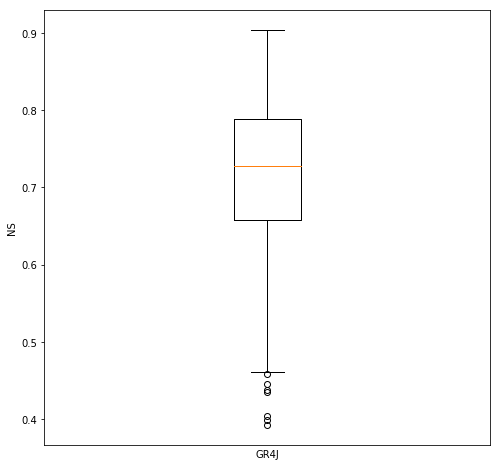

In [6]:
efficiencies = np.array(efficiencies)

plt.figure(figsize=(8,8))
plt.boxplot(efficiencies)

#https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.xlabel("GR4J")
plt.ylabel("NS")

In [7]:
np.median(efficiencies)

0.72771207721941167